In [1]:
import pandas as pd
import torch
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils.utils_train import train_supervised, train_models_in_threads, test_model_in_batches
from utils.utils_plots import plot_interesting_features, plot_metric_data, save_figure, plot_cluster_data
from utils.utils_dataset import balance_dataset, prepare_dataset, balance_data_for_clients
from utils.utils_dataset import display_dataset_split
from utils.utils_metrics import calculate_metrics, plot_confusion_matrix, calculate_roc_auc
import threading
import itertools
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
import pandas as pd
import concurrent.futures
import os
import copy
import time

In [2]:
from model.eGauss_plus import eGAUSSp

In [3]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)
feature_dim = 29

# Remove the first dimension/column
data = data.drop(data.columns[0], axis=1)

# Compute the ranges
ranges = data.max() - data.min()

# Display the ranges
print(ranges)

'''
# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to normalize - all except 'Class'
cols_to_normalize = [col for col in data.columns if col != 'Class']

# Apply the normalization
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

# Set the number of PCA components
feature_dim = 10  # Change this value to adjust the number of components

# Initialize PCA
pca = PCA(n_components=feature_dim)

# Apply PCA to the normalized data
# Note that we don't apply PCA to the 'Class' column
pca_data = pca.fit_transform(data[cols_to_normalize])

# Create a DataFrame with PCA results and the 'Class' column
pca_columns = ['PC' + str(i+1) for i in range(feature_dim)]
pca_data_df = pd.DataFrame(pca_data, columns=pca_columns)
pca_data_df['Class'] = data['Class']

data = pca_data_df
'''

V1           58.862440
V2           94.773457
V3           57.708148
V4           22.558515
V5          148.544973
V6           99.462131
V7          164.146736
V8           93.223927
V9           29.029061
V10          48.333399
V11          16.816387
V12          26.532107
V13          12.918764
V14          29.741092
V15          13.376686
V16          31.444966
V17          34.416326
V18          14.539815
V19          12.805499
V20          93.918625
V21          62.033221
V22          21.436234
V23          67.336147
V24           7.421176
V25          17.814986
V26           6.121896
V27          54.177877
V28          49.277892
Amount    25691.160000
Class         1.000000
dtype: float64


"\n# Initialize the StandardScaler\nscaler = StandardScaler()\n\n# Select the columns to normalize - all except 'Class'\ncols_to_normalize = [col for col in data.columns if col != 'Class']\n\n# Apply the normalization\ndata[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])\n\n# Set the number of PCA components\nfeature_dim = 10  # Change this value to adjust the number of components\n\n# Initialize PCA\npca = PCA(n_components=feature_dim)\n\n# Apply PCA to the normalized data\n# Note that we don't apply PCA to the 'Class' column\npca_data = pca.fit_transform(data[cols_to_normalize])\n\n# Create a DataFrame with PCA results and the 'Class' column\npca_columns = ['PC' + str(i+1) for i in range(feature_dim)]\npca_data_df = pd.DataFrame(pca_data, columns=pca_columns)\npca_data_df['Class'] = data['Class']\n\ndata = pca_data_df\n"

In [4]:
print(f"{torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu") #

if device == torch.device("cpu"):
    # Set the number of threads to the number of CPU cores
    num_cores = os.cpu_count()
    torch.set_num_threads(num_cores)

    os.environ['MKL_NUM_THREADS'] = '32'
    os.environ['OMP_NUM_THREADS'] = '32'
    
    # Verify the change
    print(f"Number of threads set for PyTorch: {torch.get_num_threads()}")


True


In [5]:


if 0:

    num_clients = 1

    # Define the range of values for each parameter
    num_sigma_values = [5, 10, 15, 20]
    kappa_join_values = [0.3, 0.5, 0.8]
    N_r_values = [10, 20, 30]

    # Total number of experiments
    total_experiments = len(num_sigma_values) * len(kappa_join_values) * len(N_r_values)
    completed_experiments = 0

    # Define other parameters and data setup
    local_model_params = {
        "feature_dim": feature_dim,
        "num_classes": 2,
        "kappa_n": 1,
        "S_0": 1e-10,
        "c_max": 100,
        "num_samples": 200, 
        "device": device  # Make sure 'device' is defined
    }

    # Placeholder for the best parameters and best score
    best_params = None
    best_score = 0

    # List to store all results
    results = []

    # Function to write data to a file
    def write_to_file(file_path, data, mode='a'):
        with open(file_path, mode) as file:
            file.write(data + "\n")

    # Prepare the dataset
    # Assuming prepare_dataset function and data are defined
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    client_train_unbalanced, test_data, all_data = prepare_dataset(X, y, num_clients)
    client_train = balance_data_for_clients(client_raw_data=client_train_unbalanced, balance=["random"], local_models=None, round=1)
    
    # Initialize a lock and a shared variable for progress tracking
    lock = threading.Lock()
    completed_experiments = 0
    total_experiments = len(num_sigma_values) * len(kappa_join_values) * len(N_r_values)

    # Function to execute model training and evaluation
    def train_evaluate_model(params):
        global completed_experiments
        
        num_sigma, kappa_join, N_r = params
        local_model_params.update({"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r})

        local_model = eGAUSSp(**local_model_params)
        train_supervised(local_model, client_train[0])

        _, pred_max, _ = test_model_in_batches(local_model, test_data, batch_size = 1000)
        metrics = calculate_metrics(pred_max, test_data, weight="binary")

        result_str = f"num_sigma:{num_sigma}, kappa_join:{kappa_join}, N_r:{N_r}, f1_score:{metrics['f1_score']}, precission:{metrics['precision']}, recall:{metrics['recall']}"
        print(result_str)
        write_to_file("experiment_results.txt", result_str)  # Write results to file
        
        # Update progress
        with lock:
            completed_experiments += 1
            progress = (completed_experiments / total_experiments) * 100
            print(f"Progress: {completed_experiments}/{total_experiments} ({progress:.2f}%)")

        return {"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r, "f1_score": metrics["f1_score"], "precission": metrics["precision"], "recall": metrics["recall"]}
        

    # Write initial setup data to file
    initial_setup_str = f"Initial Setup: num_clients={num_clients}, num_sigma_values={num_sigma_values}, kappa_join_values={kappa_join_values}, N_r_values={N_r_values}"
    write_to_file("experiment_results.txt", initial_setup_str, mode='w')  # 'w' to overwrite if exists

    # Using ThreadPoolExecutor to run in multiple threads
    with concurrent.futures.ThreadPoolExecutor() as executor:
        param_combinations = list(itertools.product(num_sigma_values, kappa_join_values, N_r_values))
        results = list(executor.map(train_evaluate_model, param_combinations))

    results_df = pd.DataFrame(results)


In [6]:
def write_to_file(file_path, data, mode='a'):
    with open(file_path, mode) as file:
        file.write(data + "\n")

In [7]:


def run_individual_experiment(federated_model_params, local_model_params, num_clients, num_rounds, client_raw_train, test_data, balance_techniques, test_clients=True):

    #local_model_params["c_max"] = int(federated_model_params["c_max"]/num_clients)

    # Initialize a model for each client
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)

    # Initialize a list to store the metrics for each round
    round_metrics = []
    result_file = "experiment_results.txt"
    client_train = []
    for round in range(num_rounds):
        start = time.time()

        print(f"--- Communication Round {round + 1} ---")
        round_info = f"--- Communication Round {round + 1} ---\n"
        
        client_train_old = client_train
        client_train = balance_data_for_clients(client_raw_data=client_raw_train, balance_techniques=balance_techniques, local_models=local_models, round=round)
        display_dataset_split(client_train, test_data)

        #if len(client_train_old) > 1:
        #    print(torch.sum(torch.sort(client_train[0][0])[0] - torch.sort(client_train_old[0][0])[0]))
        #aggregated_model = eGAUSSp(**federated_model_params)
        #federated_model = eGAUSSp(**federated_model_params) #Kako sicer odstrani roje, ki imajo age = 1

        # Train local models
        if device == torch.device("cpu"):
            for local_model, client_data in zip(local_models, client_train):
                train_supervised(local_model, client_data)

                print(f"Number of local model clusters = {sum(local_model.n[0:local_model.c]> local_model.kappa_n)}")
        else:        
            train_models_in_threads(local_models, client_train)

        '''
        for local_model, client_data in zip(local_models, clients_data):
             train_supervised(local_model, client_data)

             print(f"Number of local model clusters = {sum(local_model.n[0:local_model.c]> local_model.kappa_n)}")
        '''   
        
        #federated_model.age += torch.sum(federated_model.n_glo)*torch.ones_like(federated_model.age)
        # Update federated model with local models
        for client_idx, _ in enumerate(local_models):
            print(f"Num of samples in global statistics {sum(local_models[client_idx].n_glo)}")
            print(f"Number of local model clusters = {sum(local_models[client_idx].n[0:local_models[client_idx].c] > 0)}")
            # Run the forward function on the training data
            local_models[client_idx].federal_agent.federated_merging()

            # Calculate and collect metrics for each client model
            #_, client_pred, _ = test_model_in_batches(local_models[client_idx], client_train[client_idx], batch_size=500)
            #client_binary = calculate_metrics(client_pred, client_train[client_idx], "binary")
            
            #print(f"Train Metrics: {client_binary}")
            # plot_confusion_matrix(pred_max, clients_data[client_idx])

            print(f"Updating agreggated model with client {client_idx + 1}")

            federated_model.federal_agent.merge_model_privately(local_models[client_idx], local_models[client_idx].kappa_n, pred_min = 0)
            federated_model.federal_agent.federated_merging()
            
            print(f"Federated clusters after merging = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")
                
        print(f"Agreggated clusters after transfer = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")

        print("\n")
        
        # Perform federated merging and removal mechanism on the federated model
        # Evaluate federated model
        agg_clusters = []
        agg_binary = []
        #if test_clients:
        #    agg_scores, agg_pred, _ = test_model_in_batches(federated_model, test_data, batch_size=1000)
        #    agg_binary = calculate_metrics(agg_pred, test_data, "binary")
        #    agg_clusters = sum(federated_model.n[0:federated_model.c].cpu() > federated_model.kappa_n)
        #    print(f"Aggregated Metrics: {agg_binary}")

        #federated_model.federal_agent.federated_merging()
        #print(f"Federated clusters after merging = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")
    
        # Evaluate federated model
        def evaluate_federated_model(federated_model, test_data, round, fed_evaluation_results):
            # Evaluate federated model and store results in fed_evaluation_results
            fed_scores, fed_pred, _ = test_model_in_batches(federated_model, test_data, batch_size=1000)
            fed_binary = calculate_metrics(fed_pred, test_data, "binary")
            fed_roc_auc = calculate_roc_auc(fed_scores, test_data)

            # Store the results in the shared dictionary
            fed_evaluation_results['binary'] = fed_binary
            fed_evaluation_results['roc_auc'] = fed_roc_auc

            if round in [29, 30, 31]:
                plot_confusion_matrix(fed_pred, test_data)

            print("\n")

        # Return Federated Model to the Clients (end evaluate local models on test data)
        def return_to_client(client_idx, federated_model, test_data, test_clients, client_metrics, local_models):
            print(f"Returning updated model to client {client_idx + 1}")

            # Access and update the client model using its index
            local_models[client_idx].federal_agent.merge_model_privately(federated_model, 0, pred_min=0)
            local_models[client_idx].federal_agent.federated_merging()

            if test_clients:
                # Calculate and collect metrics for each client model
                _, client_pred, _ = test_model_in_batches(local_models[client_idx], test_data, batch_size=500)
                client_binary = calculate_metrics(client_pred, test_data, "binary")

                print(f"Test Metrics client {client_idx} after merge: {client_binary}")
                # plot_confusion_matrix(pred_max, clients_data[client_idx])
                
                # Update client metrics
                with threading.Lock():  # Ensure thread-safe operation
                    client_metrics.append({
                        'client_idx': client_idx,
                        'binary': client_binary,
                            'clusters': sum(local_models[client_idx].n[0:local_models[client_idx].c].cpu()> 0)
                        })
            
            #local_models[client_idx].score = torch.ones_like(local_models[client_idx].score)
            local_models[client_idx].num_pred = torch.ones_like(local_models[client_idx].num_pred)
            local_models[client_idx].age = torch.ones_like(local_models[client_idx].age)

            with torch.no_grad():    
                local_models[client_idx].S.data /= torch.min(local_models[client_idx].n[:local_models[client_idx].c].data.clone())
                local_models[client_idx].n.data /= torch.min(local_models[client_idx].n[:local_models[client_idx].c].data.clone())
                #local_models[client_idx].S[:local_models[client_idx].c].data /= local_models[client_idx].n[:local_models[client_idx].c].data.unsqueeze(-1).unsqueeze(-1)
                #local_models[client_idx].n[:local_models[client_idx].c].data /= local_models[client_idx].n[:local_models[client_idx].c].data.clone()
                local_models[client_idx].S_glo.data /= torch.sum(local_models[client_idx].n_glo.data.clone()).unsqueeze(-1)
                local_models[client_idx].n_glo.data = torch.ones_like(local_models[client_idx].n_glo)

        
        # Start the federated model evaluation in a separate thread
        fed_evaluation_results = {}               # Shared dictionary for federated model evaluation results
        fed_evaluation_thread = threading.Thread(target=evaluate_federated_model, args=(federated_model, test_data, round, fed_evaluation_results))
        fed_evaluation_thread.start()

        # Update client models in separate threads as before
        threads = []
        client_metrics = []  # Shared resource, ensure thread-safe access
        for client_idx, client_model in enumerate(local_models):
            thread = threading.Thread(target=return_to_client, args=(client_idx, federated_model, test_data, test_clients, client_metrics, local_models))
            threads.append(thread)
            thread.start()

        # Wait for all threads (including federated model evaluation) to complete
        for thread in threads:
            thread.join()
        fed_evaluation_thread.join()

        #Check transfer validity
        for client_idx, _ in enumerate(local_models):
            print(f"Number of local model clusters after transfer = {sum(local_models[client_idx].n[0:local_models[client_idx].c]> 0)}")

        with torch.no_grad():     
            federated_model.S[:federated_model.c].data /= torch.min(federated_model.n[:federated_model.c].data.clone())
            federated_model.n[:federated_model.c].data /= torch.min(federated_model.n[:federated_model.c].data.clone())
            #federated_model.S.data /= federated_model.n.data.unsqueeze(-1).unsqueeze(-1)
            federated_model.S_glo.data /= torch.sum(federated_model.n_glo).unsqueeze(-1)
            federated_model.n_glo.data = torch.ones_like(federated_model.n_glo)
            
        federated_model.federal_agent.federated_merging()
        #federated_model.num_pred = torch.ones_like(federated_model.num_pred)
        #federated_model.age = torch.zeros_like(federated_model.age)

          # Print and write round information to file
        round_info = f"--- End of Round {round + 1} ---\n"
        print(round_info)
        #write_to_file(result_file, round_info)

        round_metrics.append({
            'round': round + 1,
            'federated_model': {
                'clusters': sum(federated_model.n[0:federated_model.c].cpu() > federated_model.kappa_n),
                'binary': fed_evaluation_results['binary'],
                'roc_auc': fed_evaluation_results['roc_auc']
            },
            'aggregated_model': {
                'clusters': agg_clusters,
                'binary': agg_binary,
            },
            'client_metrics': client_metrics
        })
        
        # Plot features for the current round
        plt.close('all')  # Close all existing plots to free up memory
        if 0:
            #fig1 = plot_interesting_features(client_train[0], model=federated_model, num_sigma=federated_model.num_sigma, N_max=federated_model.kappa_n)   
            #save_figure(fig1, "./Images/credit_fraud_clusters", format='pdf')
            fig2 = plot_interesting_features(client_train[0], model=federated_model, num_sigma=2, N_max=federated_model.kappa_n)   
            save_figure(fig2, ".Images/credit_fraud_samples.pdf", format='pdf')

        # Iterate over each round's metrics and write to file
        for metric in round_metrics:
            metric_info = f"Round {metric['round']}: Metrics: {metric['federated_model']['binary']}, ROC AUC: {metric['federated_model']['roc_auc']}\n"
            print(metric_info)  # Print each round's metrics
            try:
                write_to_file(result_file, metric_info)  # Write to file
            except:
                print("Could not write to file.")
                pass

        # Save the experiments
        experiment_file = f".Results/mid_experiment_{federated_model_params['num_sigma']}_{int(federated_model_params['kappa_join']*10)}_{federated_model_params['N_r']}_{num_clients}_{len(balance_techniques)}_{federated_model_params['c_max']}.pth"
        torch.save(round_metrics, experiment_file)
        print(f"Saved experiment to {experiment_file}")
        print(f"Round time was {(time.time() - start):.1f}s")

    # After all rounds
    final_info = "All Rounds Completed. Metrics Collected:\n"
    print(final_info)
    #write_to_file(result_file, final_info)

    # Iterate over each round's metrics and write to file
    for metric in round_metrics:
        metric_info = f"Round {metric['round']}: "
        metric_info += f"Federated Model - Clusters: {metric['federated_model']['clusters']}, "
        metric_info += f"Binary Metrics: {metric['federated_model']['binary']}, ROC AUC: {metric['federated_model']['roc_auc']}\n"
        metric_info += f"Aggregated Model - Clusters: {metric['aggregated_model']['clusters']}\n"

        for client_metric in metric['client_metrics']:
            metric_info += f"Client {client_metric['client_idx']} - Binary: {client_metric['binary']}\n"

        print(metric_info)  # Print each round's metrics
        #write_to_file(result_file, metric_info)  # Write to file

    return round_metrics


In [8]:
# Define the range of values for each parameter
num_sigma_values = [10, 15, 20]
kappa_join_values = [0.3, 0.4, 0.5, 0.8, 1, 2]
N_r_values = [15, 20, 25, 30]
proportion = [5, 3, 1]

# List of client counts and data configuration indices
client_counts = [3]
data_config_indices = [1]  # Replace with your actual data configuration indices

# Assuming local_models, client_train, federated_model, and test_data are already defined
# Number of communication rounds
num_rounds = 5

In [9]:
import os

def run_experiments(data, client_counts, federated_model_params, local_model_params, num_rounds, proportions, flag_profiler=False, flag_test_clients=False):
    experiments = []
    results_dir = ".Results"  # Directory to save the results
    os.makedirs(results_dir, exist_ok=True)  # Create the directory if it doesn't exist

    for num_clients in client_counts:
        for proportion in proportions:

            print(f'\n *** Experiment details ***:\n' 
            f'  - Number of Clients: {num_clients}\n' 
            f'  - Number of Rounds: {num_rounds}\n'
            f'  - Number of Clusters: {federated_model_params["c_max"]}\n'
            f'  - Data dristribution proportions: {proportion}\n'
            f'  - num_sigma Parameter: {federated_model_params["num_sigma"]}\n'
            f'  - kappa_join Parameter: {federated_model_params["kappa_join"]}\n'
            f'  - N_r Parameter: {federated_model_params["N_r"]}')
   

            X = data.iloc[:, :-1].values
            y = data.iloc[:, -1].values
            client_raw_train, test_data, all_data = prepare_dataset(X, y, num_clients)


            balance_techniques = ['random'] * int(proportion)


            print(f"Running experiment with {num_clients} clients and data configuration {proportion}")
            
            if flag_profiler:
                # Import profiling packages only if profiler is True
                import cProfile
                import yappi
                try:
                    # Try to load the memory_profiler extension if it's available
                    get_ipython().run_line_magic('load_ext', 'memory_profiler')
                except:
                    print("Memory profiler not available.")

                print(f"... with profiler")
                pr = cProfile.Profile()
                pr.enable()
                yappi.start()
                
                metrics = run_individual_experiment(federated_model_params=federated_model_params, 
                                                    local_model_params=local_model_params, 
                                                    num_clients=num_clients, num_rounds=num_rounds, 
                                                    client_raw_train=client_raw_train, test_data=test_data,
                                                    balance_techniques=balance_techniques, test_clients=flag_test_clients)
                
                yappi.stop()
                pr.disable()

                pr.print_stats(sort='cumtime')
                yappi.get_thread_stats().print_all()
                yappi.get_func_stats().print_all()
            else:
                metrics = run_individual_experiment(federated_model_params=federated_model_params, 
                                                    local_model_params=local_model_params, 
                                                        num_clients=num_clients, num_rounds=num_rounds, 
                                                    client_raw_train=client_raw_train, test_data=test_data,
                                                    balance_techniques=balance_techniques, test_clients=flag_test_clients)

            #experiments.append((f"num_clients_{num_clients}_sampling_{proportion}", metrics))

            #Construct a specific name for the saved file
            file_name = f'experiment_metrics_num_clients_{num_clients}_rounds_{num_rounds}_proportions_{proportion}_num_sigma_{federated_model_params["num_sigma"]}_kappa_join_{int(federated_model_params["kappa_join"]*10)}_N_r_{federated_model_params["N_r"]}_clusters_{federated_model_params["c_max"]}_Fscore_{1000*metrics[-1]["federated_model"]["binary"]["f1_score"]:.0f}.pth'
            file_path = os.path.join(results_dir, file_name)

            #Save the experiments
            torch.save(metrics, file_path)
            print(f"Saved experiments to {file_path}")
            
    return experiments

In [10]:

def evaluate_metric(experiments, round_number):
    # Assuming the experiments list contains the metrics for each experiment
    # and each experiment's metrics contain the F1 score for the federated model
    for experiment in experiments:
        if experiment[1][-1]['round'] == int(round_number): #[1] is the experiment values, [0] is the name of the experiment, [-1] is the last round
            # Assuming 'binary' key contains a dictionary where 'f1_score' is one of the keys
            return experiment[1][-1]['federated_model']['binary']['f1_score']
    return None

def run_parameterized_experiments(data, client_counts, proportions, num_rounds):
    best_setting = None
    best_f1_score = -float('inf')
    all_experiments_metrics = []

    for num_sigma in num_sigma_values:
        for kappa_join in kappa_join_values:
            for N_r in N_r_values:

                    # Update the model parameters
                    federated_model_params.update({"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r})
                    local_model_params.update({"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r})

                    # Run the experiment
                    experiments = run_experiments(
                        data=data,
                        client_counts=client_counts,
                        federated_model_params=federated_model_params, 
                        local_model_params=local_model_params, 
                        num_rounds=num_rounds, 
                        proportions=proportions, 
                        flag_profiler= False,
                        flag_test_clients = False)


                    # Store all experiments' metrics
                    all_experiments_metrics.append(experiments)

                    # Evaluate the F1 score of the 5th round
                    f1_score = evaluate_metric(experiments, num_rounds)
                    
                    # Update the best setting if current setting's F1 score is better
                    if f1_score and f1_score > best_f1_score:
                        best_f1_score = f1_score
                        best_setting = (num_sigma, kappa_join, N_r, proportions)

    return best_setting, best_f1_score, all_experiments_metrics

In [11]:
from matplotlib.pyplot import flag

flag_full_experiment = 0

if flag_full_experiment:
    
    #THIS CODE RUNS THE EXPERIMENTS FOR MULTIPLE SETTING TO DETERMINE THE BEST
    best_setting, best_f1_score, all_experiments_metrics = run_parameterized_experiments(data, client_counts, data_config_indices, num_rounds)
    print("Best Setting:", best_setting)
    print("Best F1 Score:", best_f1_score)

    # Save the best setting and all experiments' metrics
    torch.save({
        "best_setting": best_setting,
        "best_f1_score": best_f1_score,
        "experiments_metrics": all_experiments_metrics
    }, 'experiment_results.pth')



 *** Experiment details ***:
  - Number of Clients: 3
  - Number of Rounds: 31
  - Number of Clusters: 1000
  - Data dristribution proportions: 5
  - num_sigma Parameter: 15
  - kappa_join Parameter: 0.4
  - N_r Parameter: 30
Running experiment with 3 clients and data configuration 5
--- Communication Round 1 ---
Client 1: {0: 640, 1: 128}
Client 2: {0: 640, 1: 128}
Client 3: {0: 640, 1: 128}
Test Set: {0: 56854, 1: 108}

Combined Number of Samples per Class:
Class 0: 58774 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 59266
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Num of samples in global statistics 768.0
Number of local model clusters = 274
Updating agreggated model with client 1
Updated var_glo values: tensor(17.4694, device='cuda:0')
Federated clusters after merging = 91
Num of samples in global statistics 768.0
Number of local

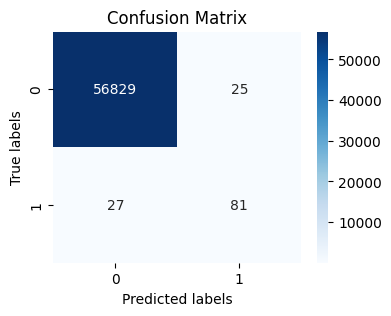



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 30 ---

Round 1: Metrics: {'accuracy': 0.9982444436641972, 'precision': 0.5256410256410257, 'recall': 0.7592592592592593, 'f1_score': 0.6212121212121211}, ROC AUC: 0.9744705086061893

Round 2: Metrics: {'accuracy': 0.99750711000316, 'precision': 0.4174757281553398, 'recall': 0.7962962962962963, 'f1_score': 0.5477707006369426}, ROC AUC: 0.9716491168411878

Round 3: Metrics: {'accuracy': 0.9984551104244935, 'precision': 0.5657894736842105, 'recall': 0.7962962962962963, 'f1_score': 0.6615384615384615}, ROC AUC: 0.969052309424139

Round 4: Metrics: {'accuracy': 0.9986131104947158, 'precision': 0.6013986013986014, 'recall': 0.7962962962962963, 'f1_score': 0.6852589641434262}, ROC AUC: 0.9554497289353236

Round 5: Metrics: {'accuracy': 0.9987008883115059, 'precision': 0.625, 'recall': 0.7870370370370371, 'f1_score': 

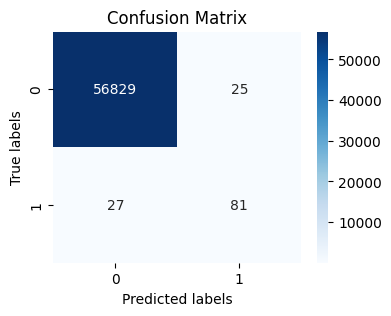



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 31 ---

Round 1: Metrics: {'accuracy': 0.9982444436641972, 'precision': 0.5256410256410257, 'recall': 0.7592592592592593, 'f1_score': 0.6212121212121211}, ROC AUC: 0.9744705086061893

Round 2: Metrics: {'accuracy': 0.99750711000316, 'precision': 0.4174757281553398, 'recall': 0.7962962962962963, 'f1_score': 0.5477707006369426}, ROC AUC: 0.9716491168411878

Round 3: Metrics: {'accuracy': 0.9984551104244935, 'precision': 0.5657894736842105, 'recall': 0.7962962962962963, 'f1_score': 0.6615384615384615}, ROC AUC: 0.969052309424139

Round 4: Metrics: {'accuracy': 0.9986131104947158, 'precision': 0.6013986013986014, 'recall': 0.7962962962962963, 'f1_score': 0.6852589641434262}, ROC AUC: 0.9554497289353236

Round 5: Metrics: {'accuracy': 0.9987008883115059, 'precision': 0.625, 'recall': 0.7870370370370371, 'f1_score': 

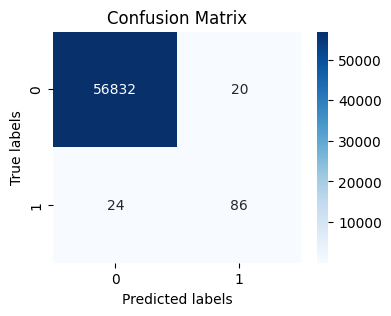



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 30 ---

Round 1: Metrics: {'accuracy': 0.9985604438046417, 'precision': 0.5933333333333334, 'recall': 0.8090909090909091, 'f1_score': 0.6846153846153846}, ROC AUC: 0.9694780066904178

Round 2: Metrics: {'accuracy': 0.9979635546504687, 'precision': 0.4838709677419355, 'recall': 0.8181818181818182, 'f1_score': 0.6081081081081081}, ROC AUC: 0.9668712382390001

Round 3: Metrics: {'accuracy': 0.9986131104947158, 'precision': 0.6068965517241379, 'recall': 0.8, 'f1_score': 0.6901960784313724}, ROC AUC: 0.9506469749205273

Round 4: Metrics: {'accuracy': 0.9986833327481479, 'precision': 0.6258992805755396, 'recall': 0.7909090909090909, 'f1_score': 0.6987951807228915}, ROC AUC: 0.9400937362082089

Round 5: Metrics: {'accuracy': 0.9988413328183702, 'precision': 0.6666666666666666, 'recall': 0.8, 'f1_score': 0.727272727272

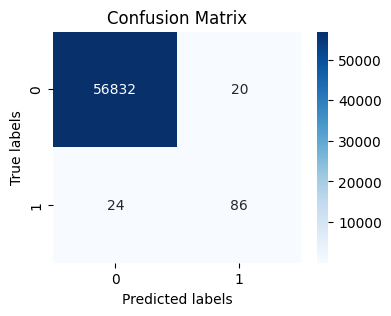



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 31 ---

Round 1: Metrics: {'accuracy': 0.9985604438046417, 'precision': 0.5933333333333334, 'recall': 0.8090909090909091, 'f1_score': 0.6846153846153846}, ROC AUC: 0.9694780066904178

Round 2: Metrics: {'accuracy': 0.9979635546504687, 'precision': 0.4838709677419355, 'recall': 0.8181818181818182, 'f1_score': 0.6081081081081081}, ROC AUC: 0.9668712382390001

Round 3: Metrics: {'accuracy': 0.9986131104947158, 'precision': 0.6068965517241379, 'recall': 0.8, 'f1_score': 0.6901960784313724}, ROC AUC: 0.9506469749205273

Round 4: Metrics: {'accuracy': 0.9986833327481479, 'precision': 0.6258992805755396, 'recall': 0.7909090909090909, 'f1_score': 0.6987951807228915}, ROC AUC: 0.9400937362082089

Round 5: Metrics: {'accuracy': 0.9988413328183702, 'precision': 0.6666666666666666, 'recall': 0.8, 'f1_score': 0.727272727272

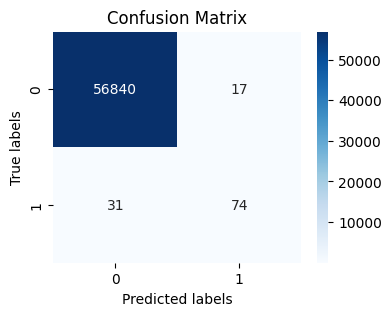



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 30 ---

Round 1: Metrics: {'accuracy': 0.9988237772550121, 'precision': 0.6696428571428571, 'recall': 0.7142857142857143, 'f1_score': 0.6912442396313364}, ROC AUC: 0.9369570442806807

Round 2: Metrics: {'accuracy': 0.9971559987359995, 'precision': 0.3686635944700461, 'recall': 0.7619047619047619, 'f1_score': 0.4968944099378882}, ROC AUC: 0.9567680655814043

Round 3: Metrics: {'accuracy': 0.998735999438222, 'precision': 0.6341463414634146, 'recall': 0.7428571428571429, 'f1_score': 0.6842105263157895}, ROC AUC: 0.9301479819463532

Round 4: Metrics: {'accuracy': 0.9985955549313578, 'precision': 0.5954198473282443, 'recall': 0.7428571428571429, 'f1_score': 0.6610169491525424}, ROC AUC: 0.9098711303294732

Round 5: Metrics: {'accuracy': 0.9990519995786665, 'precision': 0.7475728155339806, 'recall': 0.733333333333333

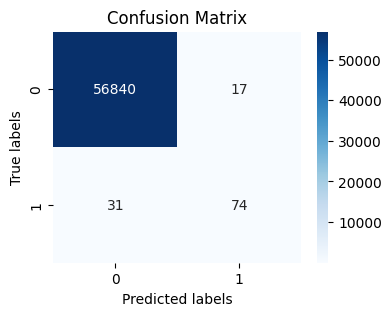



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 31 ---

Round 1: Metrics: {'accuracy': 0.9988237772550121, 'precision': 0.6696428571428571, 'recall': 0.7142857142857143, 'f1_score': 0.6912442396313364}, ROC AUC: 0.9369570442806807

Round 2: Metrics: {'accuracy': 0.9971559987359995, 'precision': 0.3686635944700461, 'recall': 0.7619047619047619, 'f1_score': 0.4968944099378882}, ROC AUC: 0.9567680655814043

Round 3: Metrics: {'accuracy': 0.998735999438222, 'precision': 0.6341463414634146, 'recall': 0.7428571428571429, 'f1_score': 0.6842105263157895}, ROC AUC: 0.9301479819463532

Round 4: Metrics: {'accuracy': 0.9985955549313578, 'precision': 0.5954198473282443, 'recall': 0.7428571428571429, 'f1_score': 0.6610169491525424}, ROC AUC: 0.9098711303294732

Round 5: Metrics: {'accuracy': 0.9990519995786665, 'precision': 0.7475728155339806, 'recall': 0.733333333333333

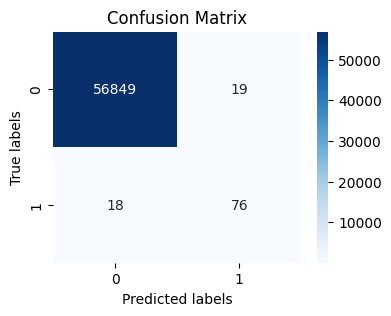



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 30 ---

Round 1: Metrics: {'accuracy': 0.9988237772550121, 'precision': 0.608, 'recall': 0.8085106382978723, 'f1_score': 0.6940639269406392}, ROC AUC: 0.9511390880561031

Round 2: Metrics: {'accuracy': 0.9970331097924933, 'precision': 0.33624454148471616, 'recall': 0.8191489361702128, 'f1_score': 0.4767801857585139}, ROC AUC: 0.9638999759053815

Round 3: Metrics: {'accuracy': 0.998156665847407, 'precision': 0.4666666666666667, 'recall': 0.8191489361702128, 'f1_score': 0.5945945945945946}, ROC AUC: 0.9644609988940419

Round 4: Metrics: {'accuracy': 0.9988413328183702, 'precision': 0.6129032258064516, 'recall': 0.8085106382978723, 'f1_score': 0.6972477064220183}, ROC AUC: 0.9417819392127196

Round 5: Metrics: {'accuracy': 0.9987711105649381, 'precision': 0.5952380952380952, 'recall': 0.7978723404255319, 'f1_score

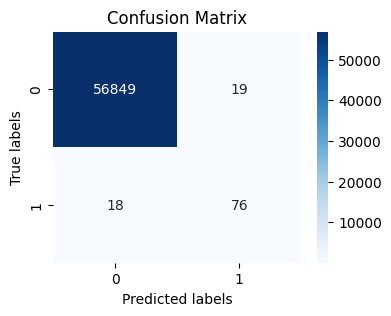



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 31 ---

Round 1: Metrics: {'accuracy': 0.9988237772550121, 'precision': 0.608, 'recall': 0.8085106382978723, 'f1_score': 0.6940639269406392}, ROC AUC: 0.9511390880561031

Round 2: Metrics: {'accuracy': 0.9970331097924933, 'precision': 0.33624454148471616, 'recall': 0.8191489361702128, 'f1_score': 0.4767801857585139}, ROC AUC: 0.9638999759053815

Round 3: Metrics: {'accuracy': 0.998156665847407, 'precision': 0.4666666666666667, 'recall': 0.8191489361702128, 'f1_score': 0.5945945945945946}, ROC AUC: 0.9644609988940419

Round 4: Metrics: {'accuracy': 0.9988413328183702, 'precision': 0.6129032258064516, 'recall': 0.8085106382978723, 'f1_score': 0.6972477064220183}, ROC AUC: 0.9417819392127196

Round 5: Metrics: {'accuracy': 0.9987711105649381, 'precision': 0.5952380952380952, 'recall': 0.7978723404255319, 'f1_score

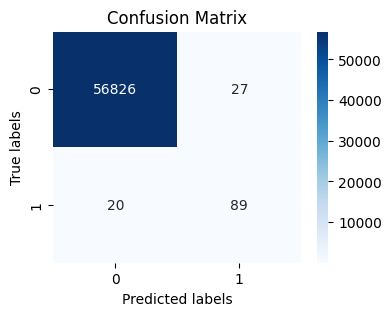



Number of local model clusters after transfer = 3980
Number of local model clusters after transfer = 3982
Number of local model clusters after transfer = 3989
--- End of Round 30 ---

Round 1: Metrics: {'accuracy': 0.9967873319054809, 'precision': 0.3483606557377049, 'recall': 0.7798165137614679, 'f1_score': 0.4815864022662889}, ROC AUC: 0.9615968398785407

Round 2: Metrics: {'accuracy': 0.9965239984551104, 'precision': 0.33579335793357934, 'recall': 0.8348623853211009, 'f1_score': 0.4789473684210526}, ROC AUC: 0.9831362937122406

Round 3: Metrics: {'accuracy': 0.9982444436641972, 'precision': 0.5263157894736842, 'recall': 0.8256880733944955, 'f1_score': 0.6428571428571429}, ROC AUC: 0.9606490390395188

Round 4: Metrics: {'accuracy': 0.9985955549313578, 'precision': 0.5973154362416108, 'recall': 0.8165137614678899, 'f1_score': 0.689922480620155}, ROC AUC: 0.9387957224950165

Round 5: Metrics: {'accuracy': 0.9987008883115059, 'precision': 0.624113475177305, 'recall': 0.807339449541284

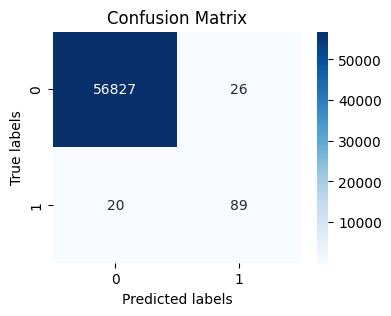



Number of local model clusters after transfer = 3984
Number of local model clusters after transfer = 3983
Number of local model clusters after transfer = 3980
--- End of Round 31 ---

Round 1: Metrics: {'accuracy': 0.9967873319054809, 'precision': 0.3483606557377049, 'recall': 0.7798165137614679, 'f1_score': 0.4815864022662889}, ROC AUC: 0.9615968398785407

Round 2: Metrics: {'accuracy': 0.9965239984551104, 'precision': 0.33579335793357934, 'recall': 0.8348623853211009, 'f1_score': 0.4789473684210526}, ROC AUC: 0.9831362937122406

Round 3: Metrics: {'accuracy': 0.9982444436641972, 'precision': 0.5263157894736842, 'recall': 0.8256880733944955, 'f1_score': 0.6428571428571429}, ROC AUC: 0.9606490390395188

Round 4: Metrics: {'accuracy': 0.9985955549313578, 'precision': 0.5973154362416108, 'recall': 0.8165137614678899, 'f1_score': 0.689922480620155}, ROC AUC: 0.9387957224950165

Round 5: Metrics: {'accuracy': 0.9987008883115059, 'precision': 0.624113475177305, 'recall': 0.807339449541284

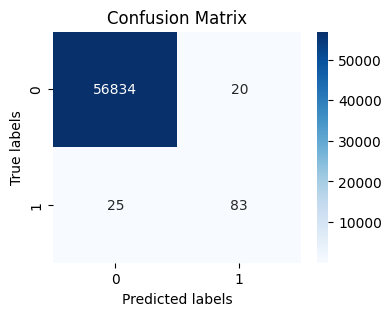



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 30 ---

Round 1: Metrics: {'accuracy': 0.9992977774656788, 'precision': 0.8333333333333334, 'recall': 0.7870370370370371, 'f1_score': 0.8095238095238095}, ROC AUC: 0.9649642717083003

Round 2: Metrics: {'accuracy': 0.9988588883817282, 'precision': 0.6692913385826772, 'recall': 0.7870370370370371, 'f1_score': 0.723404255319149}, ROC AUC: 0.9822775426075105

Round 3: Metrics: {'accuracy': 0.9990168884519505, 'precision': 0.7241379310344828, 'recall': 0.7777777777777778, 'f1_score': 0.75}, ROC AUC: 0.9673324232700002

Round 4: Metrics: {'accuracy': 0.9990519995786665, 'precision': 0.7368421052631579, 'recall': 0.7777777777777778, 'f1_score': 0.7567567567567567}, ROC AUC: 0.9507243374517445

Round 5: Metrics: {'accuracy': 0.9991748885221726, 'precision': 0.7850467289719626, 'recall': 0.7777777777777778, 'f1_score':

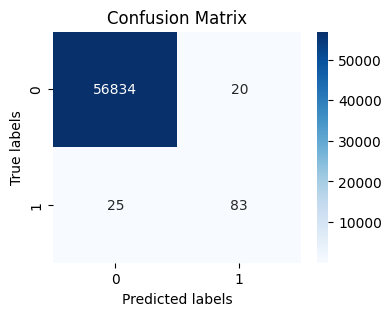



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 31 ---

Round 1: Metrics: {'accuracy': 0.9992977774656788, 'precision': 0.8333333333333334, 'recall': 0.7870370370370371, 'f1_score': 0.8095238095238095}, ROC AUC: 0.9649642717083003

Round 2: Metrics: {'accuracy': 0.9988588883817282, 'precision': 0.6692913385826772, 'recall': 0.7870370370370371, 'f1_score': 0.723404255319149}, ROC AUC: 0.9822775426075105

Round 3: Metrics: {'accuracy': 0.9990168884519505, 'precision': 0.7241379310344828, 'recall': 0.7777777777777778, 'f1_score': 0.75}, ROC AUC: 0.9673324232700002

Round 4: Metrics: {'accuracy': 0.9990519995786665, 'precision': 0.7368421052631579, 'recall': 0.7777777777777778, 'f1_score': 0.7567567567567567}, ROC AUC: 0.9507243374517445

Round 5: Metrics: {'accuracy': 0.9991748885221726, 'precision': 0.7850467289719626, 'recall': 0.7777777777777778, 'f1_score':

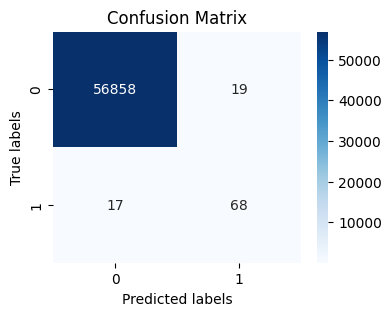



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 30 ---

Round 1: Metrics: {'accuracy': 0.9974193321863699, 'precision': 0.34183673469387754, 'recall': 0.788235294117647, 'f1_score': 0.47686832740213525}, ROC AUC: 0.9738684819357354

Round 2: Metrics: {'accuracy': 0.996875109722271, 'precision': 0.30042918454935624, 'recall': 0.8235294117647058, 'f1_score': 0.44025157232704404}, ROC AUC: 0.9791446764897214

Round 3: Metrics: {'accuracy': 0.9989993328885924, 'precision': 0.6228070175438597, 'reca

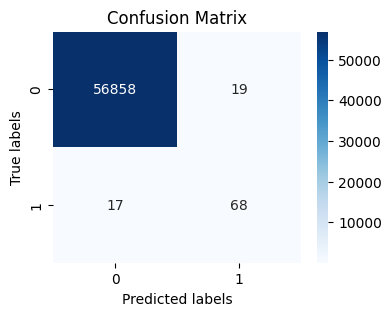



Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
Number of local model clusters after transfer = 4000
--- End of Round 31 ---

Round 1: Metrics: {'accuracy': 0.9974193321863699, 'precision': 0.34183673469387754, 'recall': 0.788235294117647, 'f1_score': 0.47686832740213525}, ROC AUC: 0.9738684819357354

Round 2: Metrics: {'accuracy': 0.996875109722271, 'precision': 0.30042918454935624, 'recall': 0.8235294117647058, 'f1_score': 0.44025157232704404}, ROC AUC: 0.9791446764897214

Round 3: Metrics: {'accuracy': 0.9989993328885924, 'precision': 0.6228070175438597, 'reca

In [12]:
# List of client counts and data configuration indices
client_counts = [10]

# Assuming local_models, client_train, federated_model, and test_data are already defined
# Number of communication rounds
num_rounds = 31

proportions = [5, 5, 5]

# Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 15,
    "kappa_join": 0.4,
    "S_0": 1e-10,
    "N_r": 30,
    "c_max": 2000,
    "num_samples": 10,
    "device": device
}

federated_model_params = {
    "feature_dim": feature_dim,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 15,
    "kappa_join": 0.4,
    "S_0": 1e-10,
    "N_r": 30,
    "c_max": 30,
    "num_samples": 10,
    "device": device
}

if flag_full_experiment:
    # Update the model parameters with the best setting
    federated_model_params.update({
        "num_sigma": best_setting[0],
        "kappa_join": best_setting[1],
        "N_r": best_setting[2]
    })

    local_model_params.update({
        "num_sigma": best_setting[0],
        "kappa_join": best_setting[1],
        "N_r": best_setting[2]
    })

    # Set the number of rounds and proportion with the best setting
    proportion = best_setting[3]

else:
    pass

# Run the experiments with the best setting for 30 rounds
experiments = run_experiments(
            data=data, 
            client_counts=client_counts,
            federated_model_params=federated_model_params, 
            local_model_params=local_model_params, 
            num_rounds=num_rounds, 
            proportions=proportions, 
            flag_profiler=False,
            flag_test_clients = False)


In [ ]:
name = "experiment_metrics_num_clients_3_rounds_31_proportions_5_num_sigma_15_kappa_join_4_N_r_30_clusters_300_Fscore_778.pth"
experiments = torch.load(f".Results/{name}")            

In [ ]:
figs_metrics = []
figs_clusters = []
experiment_name = []
rounds_max = 30
if len(name)>40:
        metrics = experiments
        rounds = [m['round'] for m in metrics]
        if rounds[-1] > rounds_max:
             rounds = rounds[:rounds_max]
             metrics = metrics[:rounds_max]
        # Plot and collect figures
       
        figs_metrics.append(plot_metric_data(metrics, ['f1_score', 'precision', 'recall'], rounds, ''))
        figs_clusters.append(plot_cluster_data(metrics, rounds))
        print(f"{100*metrics[-1]['federated_model']['binary']['f1_score']:.0f}")
else:
        rounds = [m['round'] for m in experiments]
        if rounds[-1] > rounds_max:
             rounds = rounds[:rounds_max]
             experiments = experiments[:rounds_max]
        # Plot and collect figures
        figs_metrics.append(plot_metric_data(experiments, ['f1_score', 'precision', 'recall'], rounds,"", legend=experiments))
        figs_clusters.append(plot_cluster_data(experiments, rounds, legend=experiments))
        print(f"{100*experiments[-1]['federated_model']['binary']['f1_score']:.0f}")
# Save figures from fig_metrics
for i, figure in enumerate(figs_metrics):
    save_path = f".Images/credit_fraud_metrics_{name}.pdf"
    save_figure(figure, save_path, "pdf")

# Save figures from fig_clusters
for i, figure in enumerate(figs_clusters):
    save_path = f".Images/credit_fraud_clusters_{name}.pdf"
    save_figure(figure, save_path, "pdf")

In [ ]:
import re
import numpy as np


# Function to extract settings from filename
def extract_settings(filename):
    pattern = r"(num_clients|rounds|proportions|num_sigma|kappa_join|N_r|clusters)_([0-9]+)"
    matches = re.findall(pattern, filename)
    return {match[0]: int(match[1]) for match in matches}

# Load all experiments and group by settings
experiments_by_settings = {}
directory = ".Results"
round_of_interest = 30  # Specify the round of interest

for filename in os.listdir(directory):
    if filename.startswith("experiment_metrics_"):
        settings = extract_settings(filename)
        settings_key = tuple(sorted(settings.items()))

        if settings_key not in experiments_by_settings:
            experiments_by_settings[settings_key] = []

        experiment_data = torch.load(f"{directory}/{filename}")
        experiments_by_settings[settings_key].append(experiment_data)

# Calculate average and std of F1 score at 30th round for each settings group
f1_scores_by_settings = {}

for settings, experiments in experiments_by_settings.items():
    f1_scores = []

    for experiment in experiments:
        if len(experiment) >= round_of_interest:
            f1_score = experiment[round_of_interest - 1]['federated_model']['binary']['f1_score']
            f1_scores.append(f1_score)

    if f1_scores:
        avg_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)
        f1_scores_by_settings[settings] = {'average': avg_f1, 'std_dev': std_f1}

    for settings, scores in f1_scores_by_settings.items():
        settings_str = ', '.join(f"{key}={value}" for key, value in settings)
    avg_f1 = scores['average']
    std_f1 = scores['std_dev']
    print(f"Settings: {settings_str} -> Average F1 Score: {avg_f1:.4f}, Standard Deviation: {std_f1:.4f}")